<a href="https://colab.research.google.com/github/Efefefef/IANNwTF-UniOsnabrueck/blob/main/homework06/homework06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HOMEWORK 06

**Overview on the result from Homework 05**
Batch size: 32, Epochs: 10, Optimizer: Adam

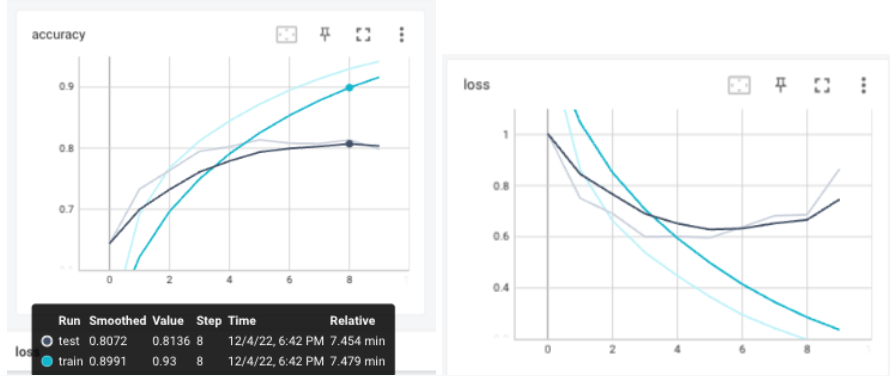

The proposed model on homework 05 has an overfitting on the CIFAR-10 dataset. According to the accuracy and loss plot, the model performs really well in the training data as indicate by high accuracy (around 0.93) and low value of loss (close to 0). However, the model cannot maintain its performance in the test data which means unable to generalise the data. It is indicated by the lower accuracy of a value around 0.8 and high loss around 0.7


### Side notes

While implementing data augmentation layer, there were following warnings


```
WARNING:tensorflow:Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
    
WARNING:tensorflow:Using a while_loop for converting Bitcast cause there is no registered converter for this op.
```

According to most forums in stack overflow [1](https://stackoverflow.com/questions/73770146/warningtensorflowusing-a-while-loop-for-converting-cause-there-is-no-registere), [2](https://stackoverflow.com/questions/73304934/tensorflow-data-augmentation-gives-a-warning-using-a-while-loop-for-converting), there was a bug in keras version 2.9 and 2.10 which causes the warning and layers works very slow. Thus, we change the tensorflow version as the warning does not occur in that version. We use following code:

```!pip install tensorflow==2.8.3```

In [1]:
!pip install tensorflow==2.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 498.4 MB 26 kB/s 
     |████████████████████████████████| 462 kB 64.3 MB/s 
     |████████████████████████████████| 5.8 MB 75.1 MB/s 
     |████████████████████████████████| 1.4 MB 70.1 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully un

# BUILDING MODEL

In [2]:
!pip install tensorflow_datasets tqdm > /dev/null

In [9]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import random

In [4]:
# Validate the version, we need 2.8.3
print(tf.__version__)

2.8.3


In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

## Prepare Dataset and Visualisation

In [66]:
# Load CIFAR10 dataset
def load_data():
    (train_ds, test_ds), ds_info = tfds.load('cifar10', 
                                             split=['train', 'test'], 
                                             as_supervised=True, 
                                             with_info=True)
    
    return (train_ds, test_ds), ds_info

In [71]:
# Check Dataset Information
(train_ds,test_ds), ds_info = load_data()

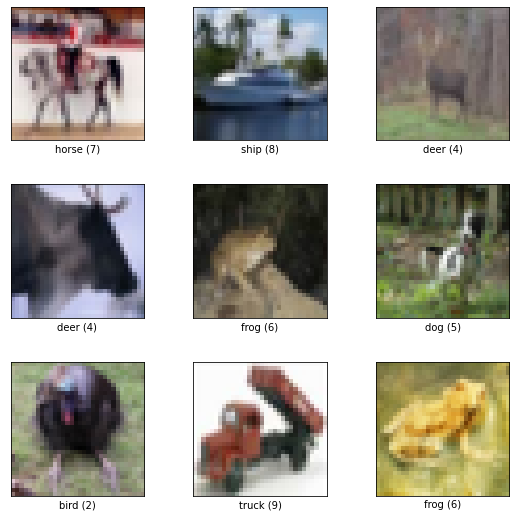

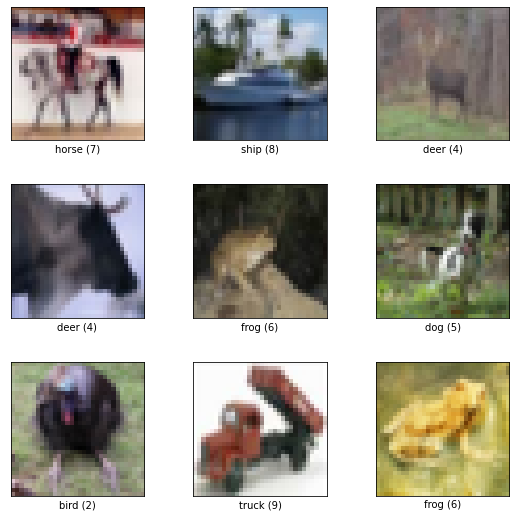

In [68]:
# Visualising dataset

# for trying if data augmentation works
# not most beautiful, but it works :)
"""train_ds = train_ds.map(lambda img, target: (tf.reverse(img, axis=[-2]), target) if random.random() < 0.3 else (img, target))
print("data flipped left right") 

train_ds = train_ds.map(lambda img, target: (tf.reverse(img, axis=[-3]), target) if random.random() < 0.3 else (img, target))
print("data flipped upside down")

for idx, (img1, label1) in enumerate(train_ds):
  print(img1.shape, label1.shape)
  plt.imshow(img1[idx])       
  plt.show()
  if idx >10:
    break"""
     

tfds.show_examples(train_ds, ds_info)

**About dataset**:
- 32x32 colour images
- training: 50,000
- test: 10,000
- label: 10 categories
- datatype: tf.uint8

In [73]:
def preprocess(data, augment=False, input_normalisation=False):
  # convert (uint8 to float32)
  data = data.map(lambda img, target: (tf.cast(img, tf.float32), target))
  
  if input_normalisation:
    data = data.map(lambda img, target: (tf.image.per_image_standardization(img),target))
  else:
    # normalisation ( [0, 255] to [-1, 1] )
    data = data.map(lambda img, target: ((img/128.)-1., target))

  # create one-hot targets (10 classes)
  data = data.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
  
  # caching transformation on dataset 
  data = data.cache()
  
  #shuffle, batch, prefetch
  data = data.shuffle(1000)
  data = data.batch(32)
  
  if augment:
    # flip each image left-right with a chance of 0.3
    data = data.map(lambda img, target: (tf.reverse(img, axis=[-2]), target) if random.random() < 0.3 else (img, target))
    # flip each image upside-down with a chance of 0.3
    data = data.map(lambda img, target: (tf.reverse(img, axis=[-3]), target) if random.random() < 0.3 else (img, target))


  data = data.prefetch(tf.data.AUTOTUNE)
  
  #return preprocessed dataset
  return data

In [ ]:
# Apply function prepare_data to dataset
train_ds = train_ds.apply(preprocess)
test_ds = test_ds.apply(preprocess)

## Training Network

In [11]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path):
    for epoch in range (epochs):
        model.reset_metrics()

        for data in tqdm(train_ds, position=0,leave=True):
            model.train_step(data)

        with train_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)
        
        print("Epoch: ", epoch+1)
        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Train)")
        model.reset_metrics()

        for data in test_ds:
            model.test_step(data)

        with test_summary_writer.as_default():
            tf.summary.scalar(model.metrics[0].name, model.metrics[0].result(), step=epoch)
            tf.summary.scalar(model.metrics[1].name, model.metrics[1].result(), step=epoch)

        print("Loss: ", model.metrics[1].result().numpy(), "Accuracy: ", model.metrics[0].result().numpy(), "(Test)")
    
    model.save_weights(save_path)

## The Densenet Model augmented with optional regularization options

In [12]:
# Class: LAYER on DenseNet
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters, kernel_regularizer=None):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu', kernel_regularizer=kernel_regularizer)

  def call(self, x):
    c = self.conv(x)
    # not taking it as output but concatinating them
    # then will be stacking all the way to the next layer
    x = tf.concat((x,c), axis=-1) 
    return x

# Class: BLOCK on DenseNet
class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers, kernel_regularizer=None, batch_norm=False):
    super().__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters, kernel_regularizer) for _ in range(layers)]
    if batch_norm:
      self.layers.append(tf.keras.layers.BatchNormalization())
  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

# Class: NETWORK of DenseNet
class CNN(tf.keras.Model):
  def __init__(self, optimizer, loss_function, L2_reg=0, batch_norm=False):
    super().__init__()
    kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None
    # num_filters = 24 / n layers = 4
    self.denseblock1 = DenselyConnectedCNNBlock(24,4, kernel_regularizer=kernel_regularizer, batch_norm=batch_norm)
    self.pooling1 = tf.keras.layers.MaxPooling2D()
    # 16x16 resolution (from original 32 x 32)
    self.denseblock2 = DenselyConnectedCNNBlock(48,4, kernel_regularizer=kernel_regularizer, batch_norm=batch_norm)
    self.pooling2 = tf.keras.layers.MaxPooling2D()
    # 8x8 resolution (from input 16 x 16)
    self.denseblock3 = DenselyConnectedCNNBlock(96,4, kernel_regularizer=kernel_regularizer, batch_norm=batch_norm)
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')

    self.optimizer = optimizer
    self.loss_function = loss_function

    self.metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Mean(name="loss")
    ]

  def call(self,x):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.out(x)
    return x

  # reset all metrics
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

  def train_step(self, data):
      image, label = data

      with tf.GradientTape() as tape:
          prediction = self(image, training = True)
          loss = self.loss_function(label, prediction)

      gradients = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)


  def test_step(self, data):
      image, label = data
      prediction = self(image, training = False)
      loss = self.loss_function(label, prediction)
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)



## Training the Densenet Model from hw05 without any extra optimisation

In [ ]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'densenet_no_optimisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

# Optimisation

In [13]:
n_epoch = 1 #useful to change it when checking if the code works

## Optimisation 1 - Data Augmentation
**Data augmentation is** a method to introduce diversity in the training set by adding the transformation from the data itself. In image processing, followings are common ways to augment the data: gray scalling, zooming, cropping, flipping, color modification, geometric tranformation, etc.

Data augmentation has following **advantages**:
* reducing cost in data collection and labelling
* preventing data scarcity as it maintains imbalance issue

Meanwhile, the **limitations** are:
* add limitation here


<div>
    <p><small>references</small></p>
    <a href="https://www.analyticssteps.com/blogs/data-augmentation-techniques-benefits-and-applications">analyticsteps.com</a>
</div>

In [74]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, augment=True)
test_ds = preprocess(test_ds)

epochs = 15

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)

optimisation_name = 'densenet_data-augmentation'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

# Running training loop
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

  0%|          | 4/1563 [00:04<32:10,  1.24s/it]


KeyboardInterrupt: ignored

## Optimisation 2 - Dropout
Dropout layer is ....


According to the [best practice](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/#:~:text=Tips%20for%20Using,to%20improve%20results.), following are consideration in using it:
* summarise the idea here (will be added by me soon :))

In CNN, dropout is only used after the pooling layers [[source]](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/#:~:text=Tips%20for%20Using,to%20improve%20results.)

In [ ]:
# ADDING DROPOUT LAYER TO THE ARCHITECTURE

# Class: LAYER on DenseNet
class DenselyConnectedCNNLayer(tf.keras.layers.Layer):
  def __init__(self, num_filters):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same', activation='relu')

  def call(self, x):
    c = self.conv(x)
    # not taking it as output but concatinating them
    # then will be stacking all the way to the next layer
    x = tf.concat((x,c), axis=-1) 
    return x

# Class: BLOCK on DenseNet
class DenselyConnectedCNNBlock(tf.keras.layers.Layer):
  def __init__(self, num_filters, layers):
    super().__init__()
    self.layers = [DenselyConnectedCNNLayer(num_filters) for _ in range(layers)]

  def call(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

# Class: NETWORK of DenseNet
class CNN(tf.keras.Model):
  def __init__(self, optimizer, loss_function):
    super().__init__()
    # num_filters = 24 / n layers = 4
    self.denseblock1 = DenselyConnectedCNNBlock(24,4)
    self.pooling1 = tf.keras.layers.MaxPooling2D()
    # 16x16 resolution (from original 32 x 32)
    self.denseblock2 = DenselyConnectedCNNBlock(48,4)
    self.pooling2 = tf.keras.layers.MaxPooling2D()
    # 8x8 resolution (from input 16 x 16)
    self.denseblock3 = DenselyConnectedCNNBlock(96,4)
    
    self.globalpooling = tf.keras.layers.GlobalAvgPool2D()
    self.out = tf.keras.layers.Dense(10, activation='softmax')
    
    self.dropout_layer= tf.keras.layers.Dropout(rate=0.2)
    self.optimizer = optimizer
    self.loss_function = loss_function

    self.metrics_list = [
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Mean(name="loss")
    ]

  def call(self,x, training=None):
    x = self.denseblock1(x)
    x = self.pooling1(x)
    x = self.dropout_layer(x, training=training)
    x = self.denseblock2(x)
    x = self.pooling2(x)
    x = self.dropout_layer(x, training=training)
    x = self.denseblock3(x)
    x = self.globalpooling(x)
    x = self.dropout_layer(x, training=training)
    x = self.out(x)
    return x

  # reset all metrics
  def reset_metrics(self):
      for metric in self.metrics:
          metric.reset_states()

  def train_step(self, data):
      image, label = data

      with tf.GradientTape() as tape:
          prediction = self(image, training = True)
          loss = self.loss_function(label, prediction)

      gradients = tape.gradient(loss, self.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients,self.trainable_variables))
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)


  def test_step(self, data):
      image, label = data
      prediction = self(image, training = False)
      loss = self.loss_function(label, prediction)
      self.metrics[0].update_state(label, prediction)
      self.metrics[1].update_state(loss)

In [ ]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, augment=False)
test_ds = preprocess(test_ds)

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)
epochs = n_epoch

optimisation_name = 'densenet_dropout-layer'

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)

# Running training loop
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

## Optimisation 3 - L2 Regularisation
L2 regularisation  helps against overfitting by tackling the problem of large weights. The loss is penalised by the square of the weight. This way, smaller weights are preferred. 
L2 works better against overfitting than L1. 


In [ ]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'densenet_l2-regularisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function, L2_reg=0.001)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

## Optimisation 4 - Batch normalisation
We use BatchNorm to normalize the activations of the channels in the last convolutional layer of our convolutional layer blocks. This brings the activations closer to a standard normal distribution. When all channel activations have activations of the same scale, the gradients will also be of the same scale and it will be easier to learn for the network. In the long run, batch normalisation can also help against vanishing/exploding gradients. 

In [ ]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

optimisation_name = 'densenet_batch-normalisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function, batch_norm=True)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)

## Optimisation 5 - Input Normalisation
We already use an approximated input normalization in our preprocessed function. This approximated function is not exactly centered around 0 and the values are bound between -1 and 1. In this input normalization, we make the mean=0 and will have a standard deviation of 1.
It will be interesting to see, how good the approximation to the "real" input normalisation will be!
Normalising the input around 0 with a small standard deviation is always a good idea in image data, because pixel values between 0 and 255 can lead to high activations and gradients which can lead to problems in learning.  


In [ ]:
(train_ds,test_ds), ds_info = load_data()
train_ds = preprocess(train_ds, input_normalisation=True)
test_ds = preprocess(test_ds, input_normalisation=True)

optimisation_name = 'densenet-input-normalisation'

optimizer = tf.keras.optimizers.Adam()
loss_function = tf.keras.losses.CategoricalCrossentropy()
cnn = CNN(optimizer=optimizer, loss_function=loss_function)
epochs = 15

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_path = f"models/{optimisation_name}/{current_time}"
train_log_path = f"logs/{optimisation_name}/{current_time}/train"
test_log_path = f"logs/{optimisation_name}/{current_time}/test"
train_summary_writer = tf.summary.create_file_writer(train_log_path)
test_summary_writer = tf.summary.create_file_writer(test_log_path)
training_loop(cnn, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer, save_path)